# Redes Neuronales
## Preparacion de datos para el modelo

In [18]:
import sys
sys.path.append('../')

import Utilidades as ut
import Modelos as md
import numpy as np
import pandas as pd


df_train = pd.read_pickle("../Archivos/Neuronales_entrenamiento.pkl")
df_test = pd.read_pickle("../Archivos/Neuronales_validacion.pkl")

x_train, y_train = ut.split_labels(df_train)
x_test, y_test = ut.split_labels(df_test)

#Convertimos las fechas a numeros (cantidad de dias transcurridos) y luego las normalizamos
x_train, x_test = ut.conversion_fechas(x_train, x_test)
x_train, x_test = ut.codificar_categoricas(x_train, y_train, x_test, modo='catboost')
x_train, x_test = ut.normalizacion_numericas(x_train, x_test, modo='normalizacion')
x_train.head(3)

/home/julian/anaconda3/envs/tensorflow/lib/python3.6/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


,Region,Territory,"Pricing, Delivery_Terms_Quote_Appr","Pricing, Delivery_Terms_Approved",Bureaucratic_Code_0_Approval,Bureaucratic_Code_0_Approved,Submitted_for_Approval,Bureaucratic_Code,Account_Created_Date,Source,...,Buro_Approved_by_Billing_Country_mean,Buro_Approved_by_Billing_Country_std,Opportunity_Duration_by_Product_Family_mean,Opportunity_Duration_by_Product_Family_std,Total_Amount_by_Product_Family_mean,Total_Amount_by_Product_Family_std,Buro_Approved_by_Product_Family,Family_Duration,Region_Duration,Territory_Duration
0,0.86,0.36,-2.05,-1.13,-0.90,-0.64,0.0,0.14,-1.35,0.69,...,-0.31,0.08,-0.01,-0.43,-0.75,-0.64,0.26,0.61,1.97,0.84
1,0.86,0.36,0.49,0.88,1.11,1.56,0.0,0.14,-0.96,0.69,...,0.11,0.54,-0.12,0.46,0.40,0.31,0.22,-0.82,-1.65,0.41
2,0.86,0.36,0.49,-1.13,1.11,-0.64,0.0,0.14,-1.29,-1.34,...,0.10,0.53,-0.28,1.48,1.99,1.37,0.69,-0.25,-0.61,-0.90


In [39]:
from sklearn.feature_selection import mutual_info_classif
import matplotlib.pyplot as plt

x_train_vector = ut.df_a_vector(x_train)
y_train_vector = ut.df_a_vector(y_train).flatten()

importances = mutual_info_classif(x_train_vector, y_train_vector)
feat_importances = pd.Series(importances, df_train.columns[0:len(df_train.columns)-1])

<AxesSubplot:>

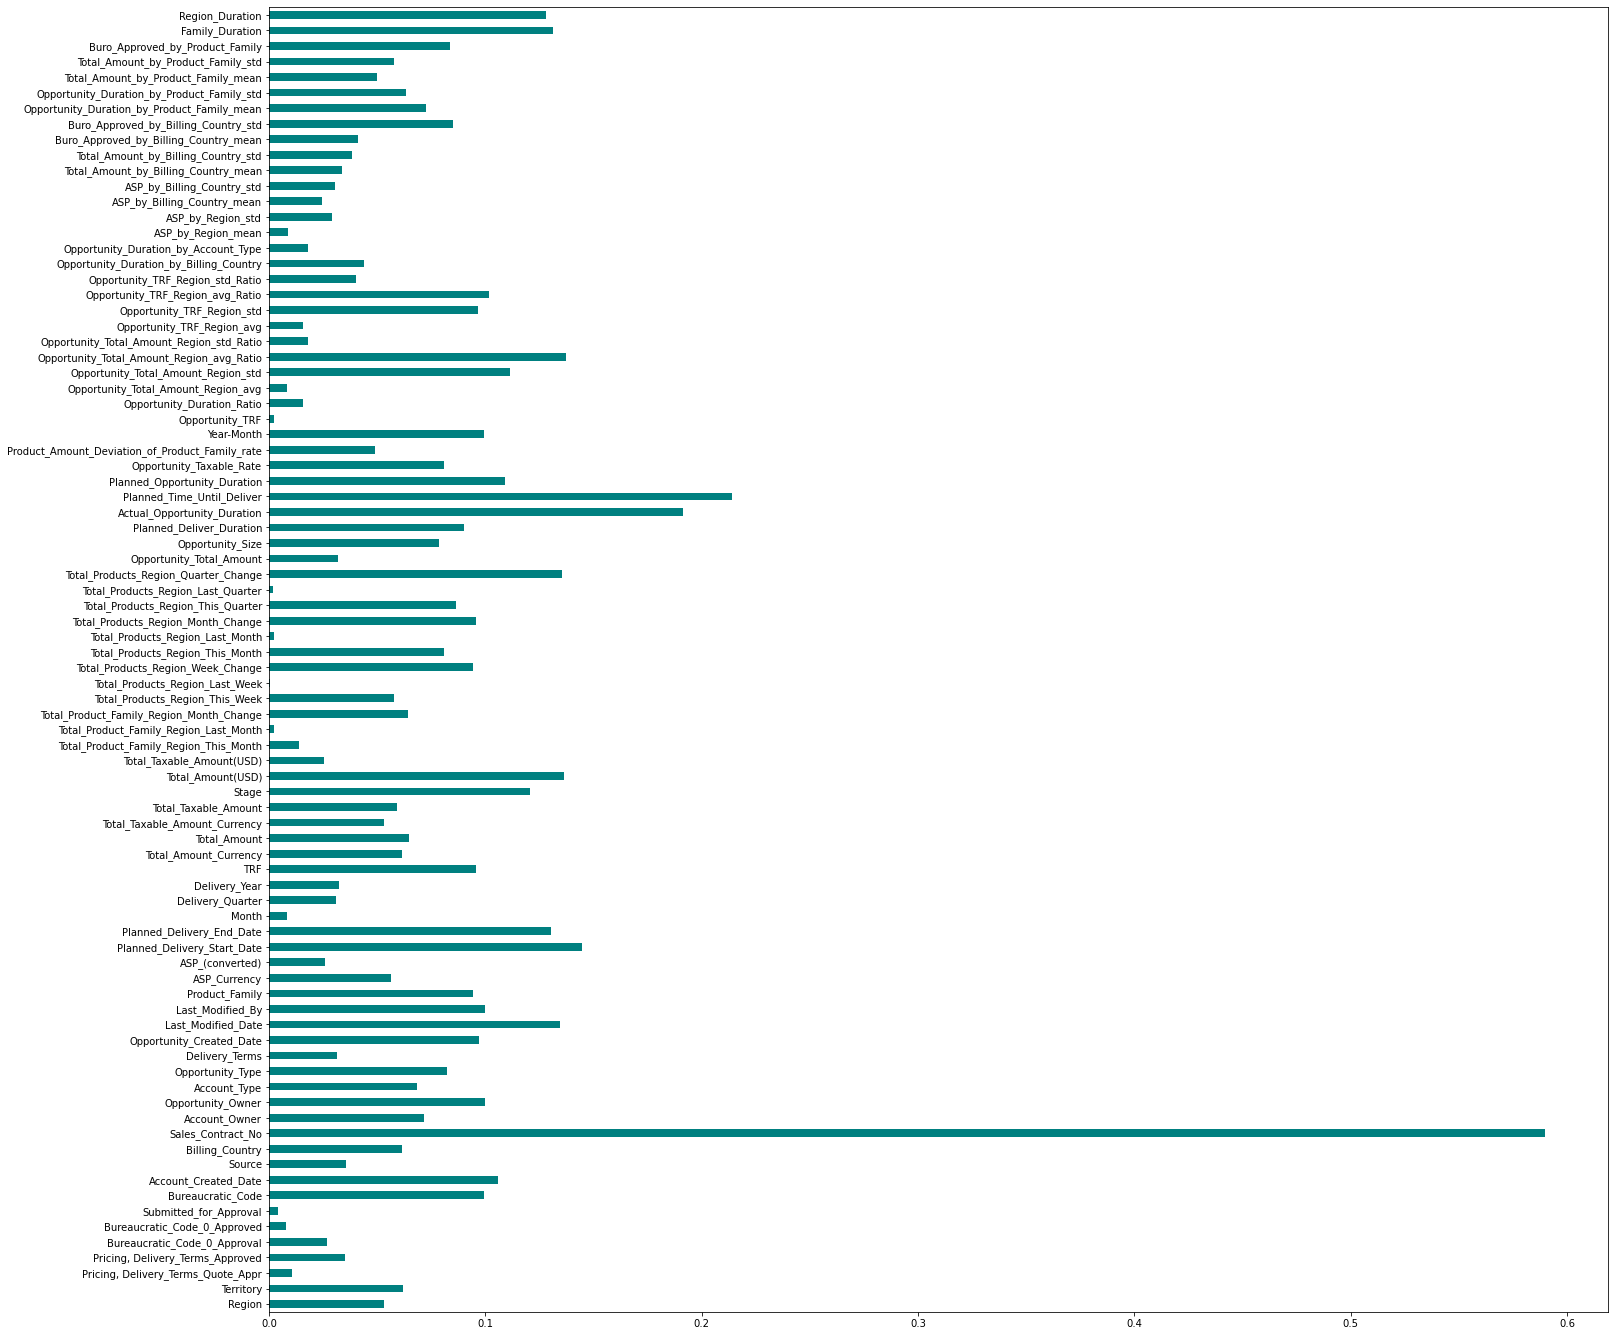

In [43]:
feat_importances.plot(kind='barh', color='teal', figsize=(24, 24))

In [48]:
from skfeature.function.similarity_based import fisher_score

dataframe = x_train.drop(columns=['Sales_Contract_No'])

x_train_vector = ut.df_a_vector(dataframe)
y_train_vector = ut.df_a_vector(y_train).flatten()

ranks = fisher_score.fisher_score(x_train_vector, y_train_vector)

feat_importances = pd.Series(ranks, dataframe.columns[0:len(dataframe.columns)])

<AxesSubplot:>

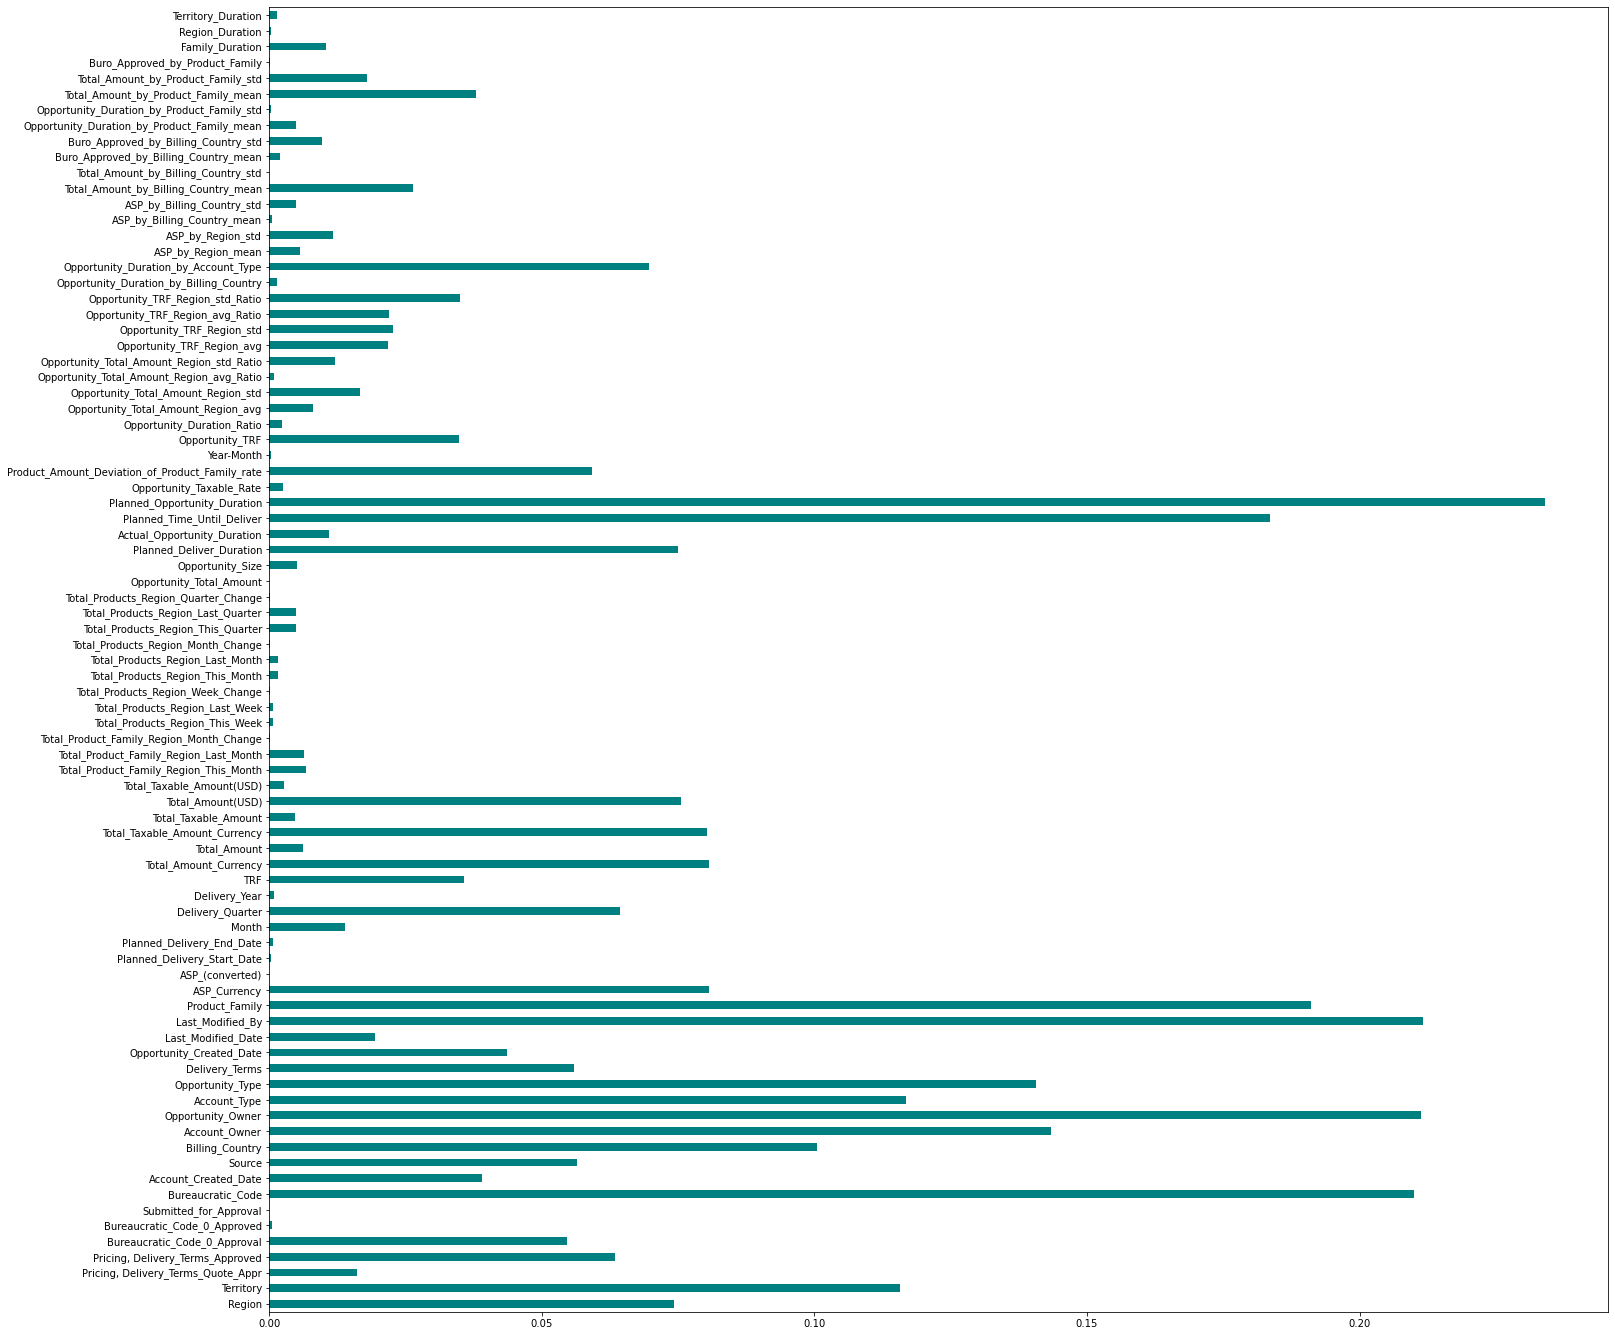

In [49]:
feat_importances.plot(kind='barh', color='teal', figsize=(24, 24))

## Creacion del modelo.

In [25]:
import keras
import tensorflow as tf
#from keras import backend
#from keras.models import Sequential
#from keras.layers import Dense
#from keras.layers import Dropout
#from keras.regularizers import l1
#from keras.regularizers import l2
#from keras.regularizers import l1_l2


x_train_vector = ut.df_a_vector(x_train)
y_train_vector = ut.df_a_vector(y_train)
x_test_vector = ut.df_a_vector(x_test)
y_test_vector = ut.df_a_vector(y_test)

#input_dim = x_train.shape[1]
#
#alfa = 1e-3
#
#model = Sequential()
#model.add(Dense(64, input_dim=input_dim, activation='relu'))
#model.add(Dropout(0.25))
#model.add(Dense(128, kernel_regularizer=l1(alfa), bias_regularizer=l1(alfa), activation='relu'))
##model.add(Dropout(0.25))
##model.add(Dense(256, kernel_regularizer=l1(alfa), bias_regularizer=l1(alfa), activation='tanh'))
#model.add(Dropout(0.5))
#model.add(Dense(128, kernel_regularizer=l1(alfa), bias_regularizer=l1(alfa), activation='relu'))
#model.add(Dropout(0.5))
#model.add(Dense(64, kernel_regularizer=l1(alfa), bias_regularizer=l1(alfa), activation='tanh'))
#model.add(Dropout(0.25))
#model.add(Dense(16, kernel_regularizer=l1(alfa), bias_regularizer=l1(alfa), activation='relu'))
#model.add(Dense(8, kernel_regularizer=l1(alfa), bias_regularizer=l1(alfa), activation='relu'))
#model.add(Dense(1, activation='tanh'))
#
#model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
#
#backend.set_value(model.optimizer.learning_rate, 5e-4)

best_hparams = ut.hyperparams_from_json('../Archivos/Neuronales')
model = md.get_neural_network_model(best_hparams, x_train.shape[1])

epochs = 300
batch_size = 256


my_callbacks = [
    tf.keras.callbacks.ModelCheckpoint("Neuronales_Mejor_Modelo.hdf5", 
                                       monitor='val_loss', 
                                       verbose=0,
                                       save_best_only=True, 
                                       mode='min'),
    
    #tf.keras.callbacks.EarlyStopping(monitor = 'val_loss',
    #                                 min_delta=0.01,
    #                                 mode='min',
    #                                 patience=10),
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                      mode='min',
                                      factor=0.5,
                                      patience=5,
                                      cooldown=0, 
                                      min_lr=1e-24)
]

fit_dict = {
    #'x' : x_train_vector,
    #'y' : y_train_vector,
    #'validation_data' : (x_test_vector, y_test_vector),
    'epochs' : epochs,
    'batch_size' : batch_size,
    'verbose' : 1,
    'callbacks' : my_callbacks
}


history = model.fit(x_train_vector,
                    y_train_vector,
                    validation_data=(x_test_vector, y_test_vector),
                    **fit_dict)


Cargando hiperparametros desde el archivo: '../Archivos/Neuronales_best_hyperparam.json'
Epoch 1/300
48/48 [==============================] - 1s 16ms/step - loss: 2625.2500 - val_loss: 771.8998 - lr: 0.0022
Epoch 2/300
48/48 [==============================] - 1s 12ms/step - loss: 227.7168 - val_loss: 33.1897 - lr: 0.0022
Epoch 3/300
48/48 [==============================] - 1s 15ms/step - loss: 21.3687 - val_loss: 17.3249 - lr: 0.0022
Epoch 4/300
48/48 [==============================] - 1s 10ms/step - loss: 16.9898 - val_loss: 17.0409 - lr: 0.0022
Epoch 5/300
48/48 [==============================] - 1s 13ms/step - loss: 16.9402 - val_loss: 16.9532 - lr: 0.0022
Epoch 6/300
48/48 [==============================] - 1s 13ms/step - loss: 16.9400 - val_loss: 16.9363 - lr: 0.0022
Epoch 7/300
48/48 [==============================] - 1s 12ms/step - loss: 16.9217 - val_loss: 17.0230 - lr: 0.0022
Epoch 8/300
48/48 [==============================] - 1s 12ms/step - loss: 16.9231 - val_loss: 16.9681 

In [20]:
#model.save('Neuronales_7740.h5')

## Resultados

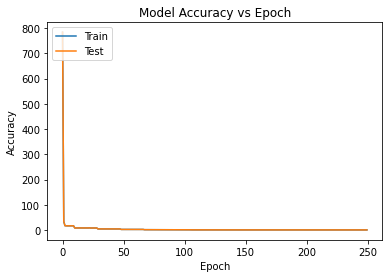

In [21]:
import matplotlib.pyplot as plt

plt.plot(history.history['val_loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Accuracy vs Epoch')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [22]:
#new_model = keras.models.load_model('Neuronales_Mejor_Modelo.hdf5')
#new_predictions = new_model.predict(x_test)

In [28]:
from sklearn.metrics import accuracy_score

y_pred = [a > 0.5 for a in model.predict(x_test_vector)]


score = accuracy_score(y_pred, y_test_vector)
score

0.6053156146179401

In [26]:
model.evaluate(x_test_vector, y_test_vector)#, metrics=['accuracy'])

142/142 [==============================] - 0s 3ms/step - loss: 0.6790


0.6790302991867065